In [20]:
## http://nbviewer.jupyter.org/github/craffel/theano-tutorial/blob/master/Theano%20Tutorial.ipynb

%matplotlib inline

## Ensure python 3 forward compatibility
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import theano

import theano.tensor as T

## Basics
foo = T.scalar('foo')

In [21]:
bar = foo ** 2
bar

Elemwise{pow,no_inplace}.0

In [22]:
print(type(bar))

<class 'theano.tensor.var.TensorVariable'>


In [23]:
print(bar.type)

TensorType(float64, scalar)


In [24]:
print(theano.pp(bar))

(foo ** TensorConstant{2})


In [25]:
f = theano.function([foo], bar)
print(f(3))

9.0


In [26]:
print(bar.eval({foo: 3}))

9.0


In [27]:
def square(x):
    return x**2
bar = square(foo)
print(bar.eval({foo: 3}))

9.0


In [28]:
## theano.tensor
A = T.matrix('A')
x = T.vector('x')
b = T.vector('b')
y = T.dot(A, x) + b
z = T.sum(A**2)

In [29]:
b_default = np.array([0,0], dtype=theano.config.floatX)
linear_mix = theano.function([A, x, theano.In(b, value=b_default)], [y, z])
# Supplying values for A, x, and b
print(linear_mix(np.array([[1,2,3],
                          [4,5,6]], dtype=theano.config.floatX), #A
                 np.array([1,2,3], dtype=theano.config.floatX), #x
                 np.array([4,5], dtype=theano.config.floatX)
                ))

## Using the default value for b
print(linear_mix(np.array([[1,2,3],
                          [4,5,6]], dtype=theano.config.floatX), #A
                 np.array([1,2,3], dtype=theano.config.floatX)))

[array([18., 37.]), array(91.)]
[array([14., 32.]), array(91.)]


In [30]:
shared_var = theano.shared(np.array([[1,2], [3,4]], dtype=theano.config.floatX))
print(shared_var.type())

<TensorType(float64, matrix)>


In [31]:
shared_var.set_value(np.array([[3,4],[2,1]], dtype=theano.config.floatX))
print(shared_var.get_value())

[[3. 4.]
 [2. 1.]]


In [32]:
shared_squared = shared_var ** 2
function_1 = theano.function([], shared_squared)
print(function_1())

[[ 9. 16.]
 [ 4.  1.]]


In [34]:
# We can also update the state of a shared var in a function
subtract = T.matrix('subtract')
# updates takes a dict where keys are shared variables and values are the new value the shared variable should take
# Here, updates will set shared_var = shared_var - subtract
function_2 = theano.function([subtract], shared_var, updates={shared_var: shared_var - subtract})
print("shared_var before subtracting [[1, 1], [1, 1]] using function_2:")
print(shared_var.get_value())
# Subtract [[1, 1], [1, 1]] from shared_var
function_2(np.array([[1, 1], [1, 1]], dtype=theano.config.floatX))
print("shared_var after calling function_2:")
print(shared_var.get_value())
# Note that this also changes the output of function_1, because shared_var is shared!
print("New output of function_1() (shared_var**2):")
print(function_1())

shared_var before subtracting [[1, 1], [1, 1]] using function_2:
[[3. 4.]
 [2. 1.]]
shared_var after calling function_2:
[[2. 3.]
 [1. 0.]]
New output of function_1() (shared_var**2):
[[4. 9.]
 [1. 0.]]


In [36]:
## Gradients
bar_grad = T.grad(bar, foo)
bar_grad.eval({foo: 10})

array(20.)

In [37]:
y_J = theano.gradient.jacobian(y, x)
linear_mix_J = theano.function([A, x, b], y_J)
print(linear_mix_J(np.array([[9,8,7], [4,5,6]], dtype=theano.config.floatX),
                  np.array([1,2,3], dtype=theano.config.floatX),
                  np.array([4,5], dtype=theano.config.floatX)))

[[9. 8. 7.]
 [4. 5. 6.]]


In [38]:
## Debugging
B = T.matrix('B')
C = T.dot(A, B)
C.eval({A: np.zeros((3,4), dtype=theano.config.floatX),
       B: np.zeros((5,6), dtype=theano.config.floatX)})

ValueError: ('shapes (3,4) and (5,6) not aligned: 4 (dim 1) != 5 (dim 0)', (3, 4), (5, 6))
Apply node that caused the error: Dot22(A, B)
Toposort index: 0
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(3, 4), (5, 6)]
Inputs strides: [(32, 8), (48, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [39]:
theano.config.compute_test_value = 'warn'
A.tag.test_value = np.random.random((3,4)).astype(theano.config.floatX)
B.tag.test_value = np.random.random((5,6)).astype(theano.config.floatX)
C = T.dot(A, B)

ValueError: shapes (3,4) and (5,6) not aligned: 4 (dim 1) != 5 (dim 0)

In [40]:
theano.config.compute_test_value = 'off'

In [41]:
num = T.scalar('num')
den = T.scalar('den')
divide = theano.function([num, den], num/den)

In [42]:
print(divide(10, 2))
print(divide(0, 0))

5.0
nan


In [43]:
divide = theano.function([num, den], num/den, mode='DebugMode')
print(divide(0, 0))

InvalidValueError: InvalidValueError
        type(variable) = TensorType(float64, scalar)
        variable       = Elemwise{true_div,no_inplace}.0
        type(value)    = <class 'numpy.ndarray'>
        dtype(value)   = float64
        shape(value)   = ()
        value          = nan
        min(value)     = nan
        max(value)     = nan
        isfinite       = False
        client_node    = None
        hint           = perform output
        specific_hint  = non-finite elements not allowed
        context        = ...
  Elemwise{true_div,no_inplace} [id A] ''   
   |num [id B]
   |den [id C]

        

In [44]:
## Using the CPU vs GPU
print(theano.config.device)
print(theano.config.floatX)

cpu
float64


In [45]:
old_floatX = theano.config.floatX
theano.config.floatX = 'float32'

In [46]:
var = theano.shared(np.array([1.3, 2.4]))

In [47]:
print(var.type())

<TensorType(float64, vector)>


In [48]:
var = theano.shared(np.array([1.3, 2.4], dtype=theano.config.floatX))
print(var.type)
theano.config.floatX = old_floatX

TensorType(float32, vector)


In [49]:
## Example MLP
class Layer(object):
    def __init__(self, W_init, b_init, activation):
        n_output, n_input = W_init.shape
        assert b_init.shape == (n_output,)
        self.W = theano.shared(value=W_init.astype(theano.config.floatX),
                              name='W',
                              borrow=True)
        self.b = theano.shared(value=b_init.reshape(n_output, 1).astype(theano.config.floatX),
                              name='b',
                              borrow=True,
                              broadcastable=(False, True))
        self.activation = activation
        self.params = [self.W, self.b]
        
    def output(self, x):
        lin_output = T.dot(self.W, x) + self.b
        return (lin_output if self.activation is None else self.activation(lin_output))
    

    
class MLP(object):
    def __init__(self, W_init, b_init, activations):
        assert len(W_init) == len(b_init) == len(activations)
        self.layers = []
        ## Construct the layers
        for W, b, activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W, b, activation))
        
        ## Combine parameters from all layers
        self.params = []
        for layer in self.layers:
            self.params += layer.params
    
    
    def output(self, x):
        for layer in self.layers:
            x = layer.output(x)
        return x
    
    def squared_error(self, x, y):
        return T.sum((self.output(x) - y)**2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  app.launch_new_instance()


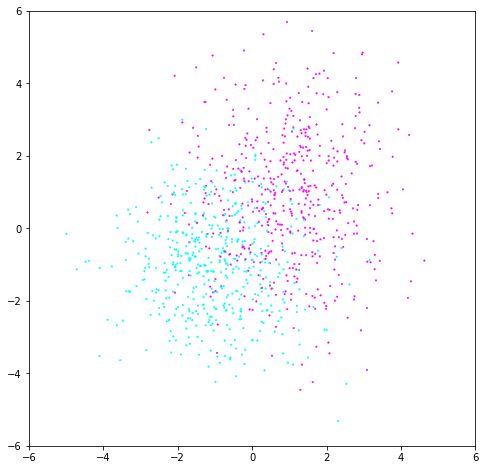

In [50]:
## Gradient descent
def gradient_updates_momentum(cost, params, learning_rate, momentum):
    assert momentum < 1 and momentum >= 0
    updates = []
    for param in params:
        previous_step = theano.shared(param.get_value()*0.,broadcastable=param.broadcastable)
        step = momentum * previous_step - learning_rate*T.grad(cost, param)
        updates.append((previous_step, step))
        updates.append((param, param + step))
    return updates


## Try Example
np.random.seed(0)
N = 1000
y = np.random.random_integers(0, 1, N)
means = np.array([[-1, 1], [-1, 1]])
covariances = np.random.random_sample((2,2)) + 1
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
              np.random.randn(N)*covariances[1, y] + means[1, y]]).astype(theano.config.floatX)
y = y.astype(theano.config.floatX)
plt.figure(figsize=(8, 8))
plt.scatter(X[0, :], X[1, :], c=y, lw=0.3, s=3, cmap=plt.cm.cool)
plt.axis([-6, 6, -6, 6])
plt.show()

In [58]:
layer_sizes = [X.shape[0], X.shape[0]*2, 1]
W_init = []
b_init = []
activations = []
for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
    W_init.append(np.random.randn(n_output, n_input))
    b_init.append(np.ones(n_output))
    activations.append(T.nnet.sigmoid)
mlp = MLP(W_init, b_init, activations)

mlp_input = T.matrix('mlp_input')
mlp_target = T.vector('mlp_target')
learning_rate = 0.01
momentum = 0.9
## Create a function for computing the cost of the network given an input
cost = mlp.squared_error(mlp_input, mlp_target)
train = theano.function([mlp_input, mlp_target], cost,
                       updates=gradient_updates_momentum(cost, mlp.params, learning_rate, momentum))
mlp_output = theano.function([mlp_input], mlp.output(mlp_input))
